In [40]:
import pandas as pd
import pickle
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score, roc_auc_score, roc_curve, confusion_matrix, classification_report, accuracy_score
import collections as c
import matplotlib.pyplot as plt
plt.style.use('ggplot')
font = {'size'   : 30}
plt.rc('font', **font)
plt.ion()
plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams["figure.figsize"] = (20.0, 10.0)
import random
%matplotlib inline
pd.set_option('display.max_columns', 2000)
pd.set_option('display.max_rows', 2000)
import warnings
warnings.filterwarnings('ignore')

In [41]:
rf_model = pickle.load(open('random_forest_completion_first_quarter.p', 'rb')) # load the model

In [42]:
rf_model.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)>

In [43]:
def standard_confusion_matrix(y_true, y_pred):
    """Make confusion matrix with format:
                  -----------
                  | TP | FP |
                  -----------
                  | FN | TN |
                  -----------
    Parameters
    ----------
    y_true : ndarray - 1D
    y_pred : ndarray - 1D

    Returns
    -------
    ndarray - 2D
    """
    [[tn, fp], [fn, tp]] = confusion_matrix(y_true, y_pred)
    return np.array([[tp, fp], [fn, tn]])

def print_roc_curve(y_test, probabilities, model_type):
    '''
    Calculates and prints a ROC curve given a set of test classes and probabilities from a trained classifier
    '''
    tprs, fprs, thresh = roc_curve(y_test, probabilities)
    plt.figure(figsize=(12,10))
    plt.plot(fprs, tprs, 
         label=model_type, 
         color='blue', 
         lw=3)
    plt.plot([0,1],[0,1], 'k:')
    plt.legend()
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title("ROC Curve AUC: {} Recall: {}".format(roc_auc, recall))
    plt.show()

In [44]:
X_test = pd.read_csv('../data/processed/first_quarter/X_test.csv')
y_test = pd.read_csv('../data/processed/first_quarter/y_test.csv')
y_test = y_test['module_not_completed']

# fill
X_test.fillna(value = 0, inplace = True)

In [45]:
    predictions = rf_model.predict(X_test)
    roc_auc = roc_auc_score(y_test, predictions)
    probas = rf_model.predict_proba(X_test)[:, :1]
    tprs, fprs, thresh = roc_curve(y_test, probas)
    recall = recall_score(y_test, predictions, average='micro')
    conf_mat = standard_confusion_matrix(y_test, predictions)
    class_report = classification_report(y_test, predictions)

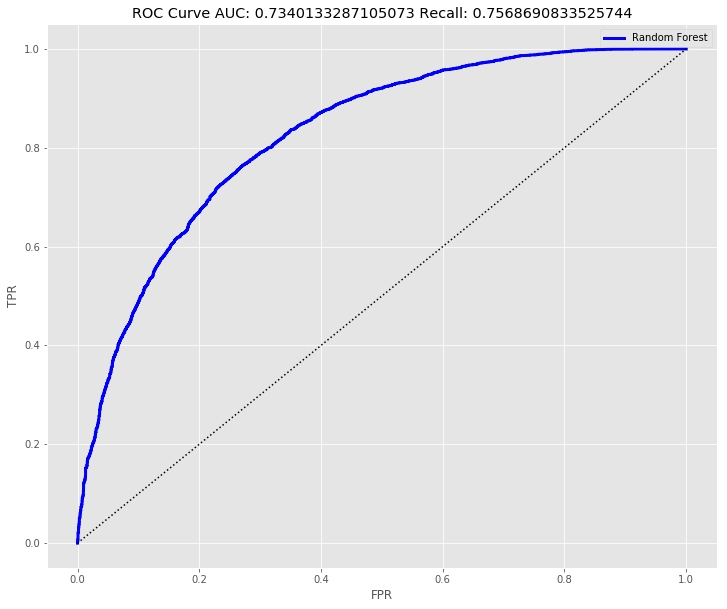

Best Model: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Roc Auc: 0.7340133287105073

Recall Score: 0.7568690833525744

Classification Report:
               precision    recall  f1-score   support

       False       0.75      0.88      0.81      5026
        True       0.78      0.59      0.67      3636

   micro avg       0.76      0.76      0.76      8662
   macro avg       0.76      0.73      0.74      8662
weighted avg       0.76      0.76      0.75      8662


Confusion Matrix:
 [[2151  621]
 [1485 4405]]


In [46]:
    print_roc_curve(y_test, probas, 'Random Forest')
    print('Best Model: {}'.format(rf_model))
    print('\nRoc Auc: {}'.format(roc_auc))
    print('\nRecall Score: {}'.format(recall))
    print('\nClassification Report:\n {}'.format(class_report))
    print('\nConfusion Matrix:\n {}'.format(standard_confusion_matrix(y_test, predictions)))

## Model Improvement Over Baseline

In [52]:
proportion = y_test.sum() / y_test.shape[0] # proportion of student who do not complete
baseline_probas = np.array([proportion] * len(y_test)) # baseline probability

In [53]:
# randomly pedict proportion = true
baseline_preds = []
for n in range(len(y_test)):
    if random.random() < proportion:
        baseline_preds.append(True)
    else:
        baseline_preds.append(False)

In [54]:
    bl_roc_auc = roc_auc_score(y_test, baseline_preds)
    probas = baseline_probas
    bl_recall = recall_score(y_test, baseline_preds, average='micro')
    bl_class_report = classification_report(y_test, baseline_preds)

## Baseline:

In [55]:
    print('\nBaseline Roc Auc: {}'.format(bl_roc_auc))
    print('\nBaseline Recall Score: {}'.format(bl_recall))
    print('\nBaseline Classification Report:\n {}'.format(bl_class_report))
    print('\nBaseline Confusion Matrix:\n {}'.format(standard_confusion_matrix(y_test, baseline_preds)))


Baseline Roc Auc: 0.49866185384953143

Baseline Recall Score: 0.5117755714615563

Baseline Classification Report:
               precision    recall  f1-score   support

       False       0.58      0.58      0.58      5026
        True       0.42      0.42      0.42      3636

   micro avg       0.51      0.51      0.51      8662
   macro avg       0.50      0.50      0.50      8662
weighted avg       0.51      0.51      0.51      8662


Baseline Confusion Matrix:
 [[1516 2109]
 [2120 2917]]


## Random Forest Model:

In [51]:
    print('\nRoc Auc: {}'.format(roc_auc))
    print('\nRecall Score: {}'.format(recall))
    print('\nClassification Report:\n {}'.format(class_report))
    print('\nConfusion Matrix:\n {}'.format(standard_confusion_matrix(y_test, predictions)))


Roc Auc: 0.7340133287105073

Recall Score: 0.7568690833525744

Classification Report:
               precision    recall  f1-score   support

       False       0.75      0.88      0.81      5026
        True       0.78      0.59      0.67      3636

   micro avg       0.76      0.76      0.76      8662
   macro avg       0.76      0.73      0.74      8662
weighted avg       0.76      0.76      0.75      8662


Confusion Matrix:
 [[2151  621]
 [1485 4405]]


## Choosing a Threshold

In [36]:
pd.DataFrame(data={'fprs': fprs, 'tprs': tprs, 'Thresholds': thresh}).loc[800:3487:200]

,fprs,tprs,Thresholds
800,0.133113,0.566057,0.717140
1000,0.171617,0.625746,0.688625
1200,0.213696,0.692002,0.651421
1400,0.257701,0.748309,0.613464
1600,0.308581,0.795862,0.576925
1800,0.360286,0.842220,0.537464
2000,0.419417,0.882411,0.491877
2200,0.487074,0.917429,0.436776
2400,0.573982,0.946677,0.369149
2600,0.669417,0.972742,0.288895


In [27]:
    t = 0.5 # threshold for predicting positive    
    predictions = (rf_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))
    print('\nConfusion Matrix at Threshold {}:\n {}'.format(t, standard_confusion_matrix(y_test, predictions)))


Classification Report at Threshold 0.5:
               precision    recall  f1-score   support

       False       0.75      0.88      0.81      5026
        True       0.78      0.59      0.67      3636

   micro avg       0.76      0.76      0.76      8662
   macro avg       0.76      0.73      0.74      8662
weighted avg       0.76      0.76      0.75      8662


Confusion Matrix at Threshold 0.5:
 [[2151  621]
 [1485 4405]]


In [28]:
    t = 0.4 # threshold for predicting positive    
    predictions = (rf_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))
    print('\nConfusion Matrix at Threshold {}:\n {}'.format(t, standard_confusion_matrix(y_test, predictions)))


Classification Report at Threshold 0.4:
               precision    recall  f1-score   support

       False       0.79      0.77      0.78      5026
        True       0.69      0.73      0.71      3636

   micro avg       0.75      0.75      0.75      8662
   macro avg       0.74      0.75      0.74      8662
weighted avg       0.75      0.75      0.75      8662


Confusion Matrix at Threshold 0.4:
 [[2637 1172]
 [ 999 3854]]


In [29]:
    t = 0.3 # threshold for predicting positive    
    predictions = (rf_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))
    print('\nConfusion Matrix at Threshold {}:\n {}'.format(t, standard_confusion_matrix(y_test, predictions)))


Classification Report at Threshold 0.3:
               precision    recall  f1-score   support

       False       0.84      0.60      0.70      5026
        True       0.61      0.85      0.71      3636

   micro avg       0.71      0.71      0.71      8662
   macro avg       0.73      0.72      0.71      8662
weighted avg       0.74      0.71      0.71      8662


Confusion Matrix at Threshold 0.3:
 [[3075 1990]
 [ 561 3036]]


In [30]:
    t = proportion # threshold for predicting positive    
    predictions = (rf_model.predict_proba(X_test)[:, 1:] > t)
    class_report = classification_report(y_test, predictions)
    print('\nClassification Report at Threshold {}:\n {}'.format(t, class_report))
    print('\nConfusion Matrix at Threshold {}:\n {}'.format(t, standard_confusion_matrix(y_test, predictions)))


Classification Report at Threshold 0.33567943348158386:
               precision    recall  f1-score   support

       False       0.82      0.67      0.74      5026
        True       0.64      0.80      0.71      3636

   micro avg       0.72      0.72      0.72      8662
   macro avg       0.73      0.73      0.72      8662
weighted avg       0.74      0.72      0.73      8662


Confusion Matrix at Threshold 0.33567943348158386:
 [[2912 1666]
 [ 724 3360]]


## Feature Importance

In [34]:
feat_imp = importances(rf_model, X_test, y_test)

In [37]:
feat_imp.sort_values(by='Importance', ascending=False)[0:20]

,Importance
Feature,
avg_score,0.0558
code_module_GGG,0.0066
highest_education_Lower Than A Level,0.0058
sum_click_page,0.0058
sum_days_vle_accessed,0.0048
score_first_assessment,0.0046
avg_days_sub_early,0.0042
sum_click_oucontent,0.0030
sum_click_subpage,0.0024
